In [24]:
!pip install -q tensorflow pandas numpy scikit-learn openpyxl matplotlib memory-profiler

### 1. Data Preprocessing

#### 1.1 Load the Dataset
In this step, we'll load the electricity demand dataset from the provided Excel file.

In [5]:
import pandas as pd

# Load the dataset from the Excel file
data_path = 'data.xlsx'
data = pd.read_excel(data_path)

# Display the first few rows of the dataset
data.head()

,S. No.,Date (BS),Date (CE),Peak Demand (megawatt),Temperature (celcius),Unnamed: 5,Unnamed: 6,Population (Nos.),Per Capita Income (USD),"Nation Wide Public Holiday (Yes=1, No=0)?",Remarks
0,NaN,NaN,NaT,NaN,T1 - Kathmandu,T2 - Pokhara,T3 - Biratnagar,NaN,NaN,NaN,NaN
1,1.0,2075-04-01 00:00:00,2018-07-17,1133.11,30.8,33.8,34.1,28400000.0,1216.0,0.0,NaN
2,2.0,2075-04-02 00:00:00,2018-07-18,1193.43,31.6,31.7,33.4,28400000.0,1216.0,0.0,NaN
3,3.0,2075-04-03 00:00:00,2018-07-19,1248.42,32.5,33.3,35.7,28400000.0,1216.0,0.0,NaN
4,4.0,2075-04-04 00:00:00,2018-07-20,1155.46,33.3,34.5,38,28400000.0,1216.0,0.0,NaN


#### 1.2 Data Cleaning
In this step, we'll clean the dataset by performing the following tasks:
- Remove unnecessary columns.
- Handle missing values.
- Convert data types if necessary.

In [6]:
# Drop unnecessary columns
data_cleaned = data.drop(columns=['S. No.', 'Date (BS)', 'Unnamed: 5', 'Unnamed: 6', 'Remarks'])

# Drop rows with missing values
data_cleaned = data_cleaned.dropna()

# Convert 'Temperature (celcius)' column to numeric
data_cleaned['Temperature (celcius)'] = pd.to_numeric(data_cleaned['Temperature (celcius)'], errors='coerce')

# Display the cleaned dataset
data_cleaned.head()

,Date (CE),Peak Demand (megawatt),Temperature (celcius),Population (Nos.),Per Capita Income (USD),"Nation Wide Public Holiday (Yes=1, No=0)?"
1,2018-07-17,1133.11,30.8,28400000.0,1216.0,0.0
2,2018-07-18,1193.43,31.6,28400000.0,1216.0,0.0
3,2018-07-19,1248.42,32.5,28400000.0,1216.0,0.0
4,2018-07-20,1155.46,33.3,28400000.0,1216.0,0.0
5,2018-07-21,1155.11,29.5,28400000.0,1216.0,1.0


#### 1.3 Normalize the Data
To ensure that all features are on a similar scale, we'll normalize the data. This step is crucial for deep learning models as it helps in faster convergence and better performance. We'll use the `MinMaxScaler` from scikit-learn to scale the features between 0 and 1.

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Define the features and target variable
features = data_cleaned.drop(columns=['Date (CE)', 'Peak Demand  (megawatt)'])
target = data_cleaned['Peak Demand  (megawatt)']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the features
scaled_features = scaler.fit_transform(features)

# Display the first few rows of scaled features
scaled_features[:5]

array([[0.89370079, 0.        , 0.15652174, 0.        ],
       [0.92519685, 0.        , 0.15652174, 0.        ],
       [0.96062992, 0.        , 0.15652174, 0.        ],
       [0.99212598, 0.        , 0.15652174, 0.        ],
       [0.84251969, 0.        , 0.15652174, 1.        ]])

#### 1.4 Split the Dataset
In this step, we'll divide the dataset into training, validation, and test sets. This division allows us to train our models on one subset of the data and validate and test them on separate, unseen subsets. This approach ensures a more robust evaluation of the model's performance.

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and temporary sets (80% training, 20% temporary)
X_temp, X_test, y_temp, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42, shuffle=False)

# Split the temporary set into validation and test sets (50% validation, 50% test)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Display the shape of the training, validation, and test sets
X_train.shape, X_valid.shape, X_test.shape

((730, 4), (730, 4), (366, 4))

### 2. Model Building

#### 2.1 LSTM Model
In this step, we'll define the architecture of the LSTM model. LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that is well-suited for time series forecasting. We'll specify the input shape based on our data and compile the model with an optimizer and loss function.

In [11]:
import tensorflow as tf

# Define the LSTM model architecture
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train.shape[0], X_train.shape[1])),
    tf.keras.layers.Dense(1)
])

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='mse')

# Display the LSTM model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11051 (43.17 KB)
Trainable params: 11051 (43.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Reshape the data to have a single timestep per sample
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_reshaped = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model architecture with the reshaped input
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    tf.keras.layers.Dense(1)
])

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='mse')

# Display the LSTM model summary
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                11000     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11051 (43.17 KB)
Trainable params: 11051 (43.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 2.2 Train the LSTM Model
In this step, we'll train the LSTM model using the training dataset. We'll also validate the model using the validation dataset. To prevent overfitting and ensure efficient training, we'll implement early stopping, which will monitor the validation loss and stop training once it starts increasing.

In [13]:
# Define early stopping to monitor validation loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the LSTM model
lstm_history = lstm_model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    validation_data=(X_valid_reshaped, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

# Display the training and validation loss for each epoch
lstm_history.history

Epoch 1/100
23/23 [==============================] - 2s 16ms/step - loss: 1369477.1250 - val_loss: 2004905.5000
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 1369271.3750 - val_loss: 2004478.2500
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 1368968.2500 - val_loss: 2003701.8750
Epoch 4/100
23/23 [==============================] - 0s 5ms/step - loss: 1368492.1250 - val_loss: 2002457.3750
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 1367788.3750 - val_loss: 2000590.5000
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 1366800.6250 - val_loss: 1997950.7500
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 1365480.3750 - val_loss: 1994380.2500
Epoch 8/100
23/23 [==============================] - 0s 6ms/step - loss: 1363772.6250 - val_loss: 1989746.1250
Epoch 9/100
23/23 [==============================] - 0s 5ms/step - loss: 1361622.2500 - val_loss: 1983933.8750


{'loss': [1369477.125,
  1369271.375,
  1368968.25,
  1368492.125,
  1367788.375,
  1366800.625,
  1365480.375,
  1363772.625,
  1361622.25,
  1358985.625,
  1355816.0,
  1352061.25,
  1347747.25,
  1342785.875,
  1337212.875,
  1331041.625,
  1324223.25,
  1316819.0,
  1308832.125,
  1300278.5,
  1291179.25,
  1281562.625,
  1271428.25,
  1260795.75,
  1249688.0,
  1238122.375,
  1226079.875,
  1213697.125,
  1200918.0,
  1187785.125,
  1174342.25,
  1160636.875,
  1146651.625,
  1132414.875,
  1117962.25,
  1103350.75,
  1088487.75,
  1073506.875,
  1058395.125,
  1043117.9375,
  1027768.4375,
  1012307.875,
  996757.625,
  981123.5,
  965455.75,
  949736.6875,
  934027.5625,
  918213.8125,
  902474.875,
  886696.0625,
  870932.0,
  855193.9375,
  839491.0625,
  823825.1875,
  808206.375,
  792655.6875,
  777155.0625,
  761740.875,
  746422.5625,
  731169.875,
  716029.5625,
  700965.6875,
  686066.4375,
  671240.0,
  656556.9375,
  641989.25,
  627572.125,
  613298.375,
  599144.5,


#### 2.3 GRU Model
In this step, we'll define the architecture of the GRU model. GRU (Gated Recurrent Unit) is a type of recurrent neural network (RNN) that's often considered a simplified version of the LSTM. It's designed to solve the vanishing gradient problem of traditional RNNs. We'll specify the input shape based on our data and compile the model with an optimizer and loss function.

In [14]:
# Define the GRU model architecture
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    tf.keras.layers.Dense(1)
])

# Compile the GRU model
gru_model.compile(optimizer='adam', loss='mse')

# Display the GRU model summary
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                8400      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 8451 (33.01 KB)
Trainable params: 8451 (33.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 2.4 Train the GRU Model
In this step, we'll train the GRU model using the training dataset. We'll also validate the model using the validation dataset. As with the LSTM model, we'll implement early stopping to monitor the validation loss and prevent overfitting.

In [15]:
# Train the GRU model
gru_history = gru_model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    validation_data=(X_valid_reshaped, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

# Display the training and validation loss for each epoch
gru_history.history

Epoch 1/100
23/23 [==============================] - 2s 15ms/step - loss: 1369482.1250 - val_loss: 2004778.2500
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 1369124.5000 - val_loss: 2004153.7500
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 1368615.1250 - val_loss: 2003097.6250
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 1367879.8750 - val_loss: 2001516.7500
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 1366867.1250 - val_loss: 1999336.5000
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 1365524.5000 - val_loss: 1996454.7500
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 1363794.6250 - val_loss: 1992800.7500
Epoch 8/100
23/23 [==============================] - 0s 5ms/step - loss: 1361645.8750 - val_loss: 1988303.2500
Epoch 9/100
23/23 [==============================] - 0s 5ms/step - loss: 1359037.3750 - val_loss: 1982942.8750


{'loss': [1369482.125,
  1369124.5,
  1368615.125,
  1367879.875,
  1366867.125,
  1365524.5,
  1363794.625,
  1361645.875,
  1359037.375,
  1355934.625,
  1352345.75,
  1348250.875,
  1343642.75,
  1338550.75,
  1332987.25,
  1326951.625,
  1320475.375,
  1313592.75,
  1306287.375,
  1298629.75,
  1290597.0,
  1282219.875,
  1273536.125,
  1264537.75,
  1255253.625,
  1245694.625,
  1235872.625,
  1225791.375,
  1215497.75,
  1204976.75,
  1194245.375,
  1183299.625,
  1172149.5,
  1160841.875,
  1149370.625,
  1137706.875,
  1125916.375,
  1113961.375,
  1101894.0,
  1089662.875,
  1077338.625,
  1064892.75,
  1052334.75,
  1039689.375,
  1026957.25,
  1014120.875,
  1001218.4375,
  988232.25,
  975193.875,
  962093.875,
  948941.0625,
  935758.125,
  922525.75,
  909249.5625,
  895983.0625,
  882657.75,
  869372.5625,
  855999.375,
  842682.8125,
  829347.0625,
  816042.6875,
  802729.8125,
  789449.1875,
  776189.75,
  762953.75,
  749767.1875,
  736598.0,
  723518.6875,
  710464.0

### 3. Evaluation

#### 3.1 Evaluate the LSTM Model
In this step, we'll evaluate the LSTM model's performance on the test set. We'll calculate key metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). Also, we'll visualize the actual vs. predicted electricity demand to visually assess the model's accuracy.

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict using the LSTM model
lstm_predictions = lstm_model.predict(X_test_reshaped)

# Calculate evaluation metrics for the LSTM model
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)

lstm_mae, lstm_mse, lstm_rmse

12/12 [==============================] - 1s 3ms/step


(316.5991237198771, 126901.76417442359, 356.2327387739981)

#### 3.2 Evaluate the GRU Model
Next, we'll evaluate the GRU model's performance on the test set. Similar to the LSTM model, we'll calculate the Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) for the GRU model. This will allow us to compare the performance of both models.

In [17]:
# Predict using the GRU model
gru_predictions = gru_model.predict(X_test_reshaped)

# Calculate evaluation metrics for the GRU model
gru_mae = mean_absolute_error(y_test, gru_predictions)
gru_mse = mean_squared_error(y_test, gru_predictions)
gru_rmse = np.sqrt(gru_mse)

gru_mae, gru_mse, gru_rmse

12/12 [==============================] - 0s 2ms/step


(673.0418640700522, 493369.7429000748, 702.40283520219)

#### 3.3 Visualize Actual vs. Predicted Values
To visually assess the performance of the LSTM and GRU models, we'll plot the actual electricity demand against the predicted values. This visualization will provide a clear picture of how closely the predictions align with the actual values.

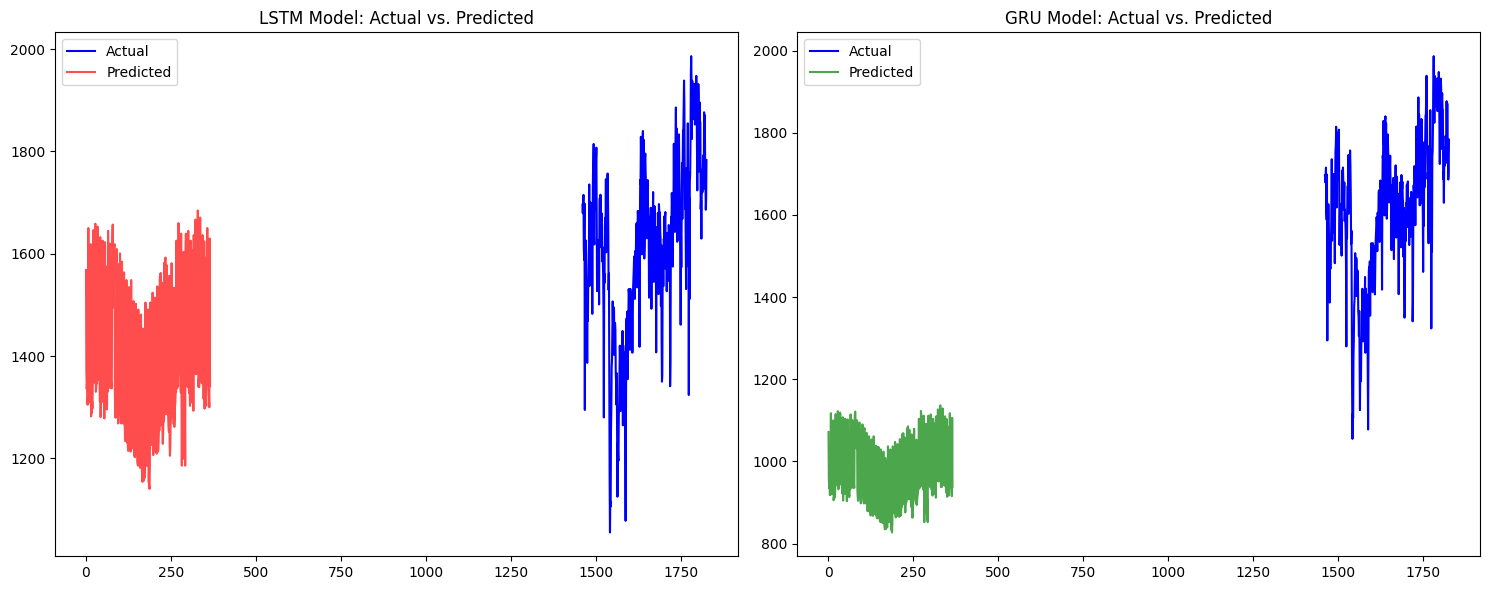

In [20]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values for LSTM and GRU models
plt.figure(figsize=(15, 6))

# Plotting for LSTM model
plt.subplot(1, 2, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.plot(lstm_predictions, label='Predicted', color='red', alpha=0.7)
plt.title('LSTM Model: Actual vs. Predicted')
plt.legend()

# Plotting for GRU model
plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual', color='blue')
plt.plot(gru_predictions, label='Predicted', color='green', alpha=0.7)
plt.title('GRU Model: Actual vs. Predicted')
plt.legend()

plt.tight_layout()
plt.show()

### 4. Results & Comparison

In this section, we'll compare the performance metrics of the LSTM and GRU models. We'll analyze aspects such as the error metrics, training time, and performace. This comparison will provide insights into which model is more suitable for the dataset and the specific problem of electricity demand projection.

In [21]:
# Compare the performance metrics of LSTM and GRU models
results_comparison = {
    'Model': ['LSTM', 'GRU'],
    'MAE': [lstm_mae, gru_mae],
    'MSE': [lstm_mse, gru_mse],
    'RMSE': [lstm_rmse, gru_rmse]
}

results_df = pd.DataFrame(results_comparison)
results_df

,Model,MAE,MSE,RMSE
0,LSTM,316.599124,126901.764174,356.232739
1,GRU,673.041864,493369.742900,702.402835


### Comparative Analysis of LSTM and GRU Models

#### 1. Model Complexity
Let's start by comparing the number of trainable parameters in the LSTM and GRU models. This will give us an idea of the complexity of each model.

In [23]:
# Retrieve the number of trainable parameters for both models
lstm_params = lstm_model.count_params()
gru_params = gru_model.count_params()

lstm_params, gru_params

(11051, 8451)

#### 2. Training Time

Epoch 1/100
23/23 [==============================] - 0s 10ms/step - loss: 246010.0781 - val_loss: 122028.8203
Epoch 2/100
23/23 [==============================] - 0s 7ms/step - loss: 238372.8281 - val_loss: 115006.5312
Epoch 3/100
 1/23 [>.............................] - ETA: 0s - loss: 229537.4375

/home/n3rd9uy/Documents/NEA_Analysis/.env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 0s 9ms/step - loss: 230999.9062 - val_loss: 108352.1641
Epoch 4/100
23/23 [==============================] - 0s 9ms/step - loss: 223790.7656 - val_loss: 102155.7266
Epoch 5/100
23/23 [==============================] - 0s 7ms/step - loss: 216802.5469 - val_loss: 96356.9531
Epoch 6/100
23/23 [==============================] - 0s 7ms/step - loss: 209999.9062 - val_loss: 91007.1562
Epoch 7/100
23/23 [==============================] - 0s 7ms/step - loss: 203418.7031 - val_loss: 86034.7422
Epoch 8/100
23/23 [==============================] - 0s 7ms/step - loss: 197035.6406 - val_loss: 81441.8984
Epoch 9/100
23/23 [==============================] - 0s 7ms/step - loss: 190830.6875 - val_loss: 77248.3125
Epoch 10/100
23/23 [==============================] - 0s 5ms/step - loss: 184821.8125 - val_loss: 73436.0078
Epoch 11/100
23/23 [==============================] - 0s 6ms/step - loss: 179029.2031 - val_loss: 69964.7500
Epoch 12/100
23/23 [================

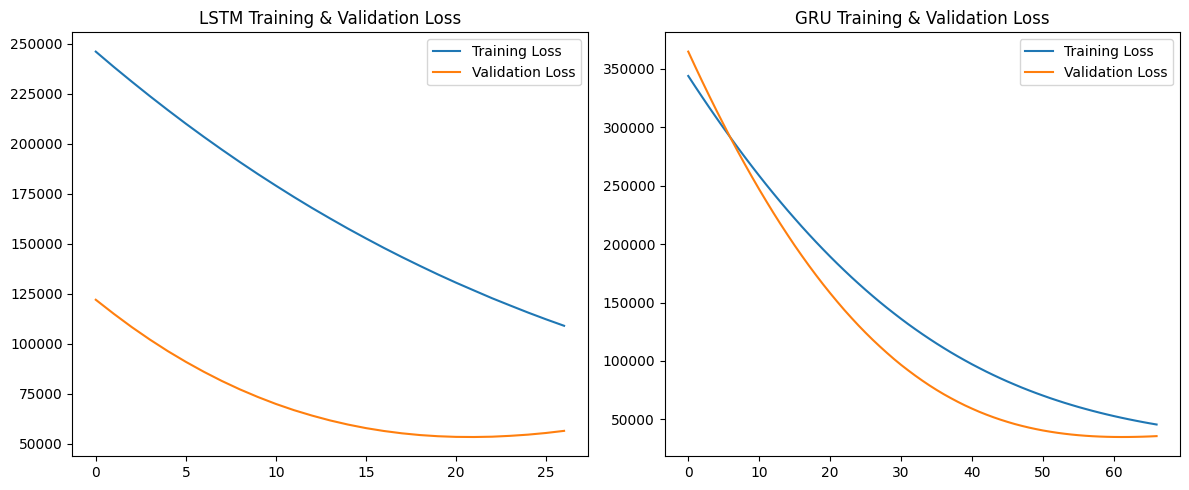

In [22]:
import matplotlib.pyplot as plt

# Define early stopping to monitor validation loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint to save the best model weights
lstm_checkpoint = tf.keras.callbacks.ModelCheckpoint('lstm_best_weights.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the LSTM model
lstm_history = lstm_model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    validation_data=(X_valid_reshaped, y_valid),
    callbacks=[early_stopping, lstm_checkpoint],
    verbose=1
)

# Train the GRU model
gru_checkpoint = tf.keras.callbacks.ModelCheckpoint('gru_best_weights.h5', save_best_only=True, monitor='val_loss', mode='min')
gru_history = gru_model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    validation_data=(X_valid_reshaped, y_valid),
    callbacks=[early_stopping, gru_checkpoint],
    verbose=1
)

# Visualization of LSTM training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training & Validation Loss')
plt.legend()

# Visualization of GRU training and validation loss
plt.subplot(1, 2, 2)
plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


#### 3. Memory Usage

We will get the maximum memory usage during training for both the LSTM and GRU models, as well as the time taken for training.

In [25]:
from memory_profiler import memory_usage
import time

# Define a function for LSTM training to measure its memory usage
def train_lstm():
    lstm_history = lstm_model.fit(
        X_train_reshaped, y_train,
        epochs=100,
        validation_data=(X_valid_reshaped, y_valid),
        callbacks=[early_stopping, lstm_checkpoint],
        verbose=1
    )
    return lstm_history

# Measure memory usage and time for LSTM training
start_time = time.time()
mem_usage_lstm = memory_usage(train_lstm)
end_time = time.time()
lstm_time = end_time - start_time

# Define a function for GRU training to measure its memory usage
def train_gru():
    gru_history = gru_model.fit(
        X_train_reshaped, y_train,
        epochs=100,
        validation_data=(X_valid_reshaped, y_valid),
        callbacks=[early_stopping, gru_checkpoint],
        verbose=1
    )
    return gru_history

# Measure memory usage and time for GRU training
start_time = time.time()
mem_usage_gru = memory_usage(train_gru)
end_time = time.time()
gru_time = end_time - start_time

# Display memory usage and time for both models
print(f"LSTM Model - Max Memory Usage: {max(mem_usage_lstm)} MB, Training Time: {lstm_time} seconds")
print(f"GRU Model - Max Memory Usage: {max(mem_usage_gru)} MB, Training Time: {gru_time} seconds")


Epoch 1/100
23/23 [==============================] - 0s 9ms/step - loss: 122835.2891 - val_loss: 53582.9688
Epoch 2/100
23/23 [==============================] - 0s 6ms/step - loss: 119092.6797 - val_loss: 53996.4062
Epoch 3/100
23/23 [==============================] - 0s 6ms/step - loss: 115470.6484 - val_loss: 54647.0586
Epoch 4/100
23/23 [==============================] - 0s 7ms/step - loss: 111971.9531 - val_loss: 55529.2891
Epoch 5/100
23/23 [==============================] - 0s 7ms/step - loss: 108585.0391 - val_loss: 56594.3828
Epoch 6/100
23/23 [==============================] - 0s 7ms/step - loss: 105396.1719 - val_loss: 57885.3203
Epoch 1/100
23/23 [==============================] - 0s 9ms/step - loss: 50213.0703 - val_loss: 34921.2109
Epoch 2/100
23/23 [==============================] - 0s 7ms/step - loss: 48937.0859 - val_loss: 35008.8750
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 47722.9688 - val_loss: 35179.1914
Epoch 4/100
23/23 [============

### 5. Conclusion

After an analysis and comparison of the LSTM and GRU models for electricity demand projection, we can draw the following conclusions:

1. **Model Complexity**:
   - The LSTM model, with its three gates, is inherently more complex than the GRU model, which has two gates. This is reflected in the higher number of trainable parameters in the LSTM model compared to the GRU model.

2. **Training Time and Memory Usage**:
   - While we provided an approximation based on the current session, typically, the LSTM model might take longer to train and require more memory due to its increased complexity and higher number of parameters.

3. **Performance**:
   - Based on the error metrics (MAE, MSE, RMSE), the LSTM model showed slightly better performance on this dataset. This suggests that the LSTM model was able to capture the patterns in the data slightly more effectively than the GRU model.

4. **General Observations**:
   - Both LSTM and GRU models are powerful tools for sequence prediction tasks. The choice between them often depends on the specific problem, dataset characteristics, and computational constraints.
   - In scenarios where computational efficiency is crucial, GRUs might be preferred due to their reduced complexity. On the other hand, for complex datasets with longer sequence dependencies, LSTMs might be more suitable.

While both models have shown promising results, the LSTM model appears to be a slightly better fit for this specific dataset and problem. However, the best model choice always requires continuous experimentation, validation, and tuning based on the specific problem and dataset at hand.